# Notebook 3: Model Setup and Evaluation

## Introduction

## Methodology

## Import Libraries

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Ridge


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [48]:
plt.style.use('seaborn')

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Read in Dataset

In [2]:
df = pd.read_csv('../data/restaurant_data_cleaned.csv')
df.head()

,latitude,longitude,stars,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,...,Cafes,Mexican,Bakeries,Japanese,Delis,Specialty Food,median_fans_per_user,checkins_per_week,reviews_per_week,tips_per_week
0,42.541155,-70.973438,4.0,39,1,1,1,1,1,2,...,0,0,0,0,0,0,0.0,0.076064,0.058773,0.041854
1,42.338544,-71.106842,2.5,24,1,1,0,1,1,1,...,0,0,0,0,0,0,9.0,0.473714,0.034599,0.036458
2,42.363442,-71.025781,3.5,856,1,0,1,1,1,2,...,0,0,0,0,0,0,3.0,5.808700,1.140674,0.366721
3,42.342673,-71.084239,4.5,7,0,1,0,1,1,1,...,0,0,0,0,0,0,0.0,0.428571,0.150769,0.125749
4,42.506935,-71.195854,3.0,16,0,1,1,1,1,1,...,0,0,0,0,0,0,0.0,0.071721,0.000000,0.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10481 entries, 0 to 10480
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitude                    10481 non-null  float64
 1   longitude                   10481 non-null  float64
 2   stars                       10481 non-null  float64
 3   review_count                10481 non-null  int64  
 4   is_open                     10481 non-null  int64  
 5   RestaurantsGoodForGroups    10481 non-null  int64  
 6   HasTV                       10481 non-null  int64  
 7   GoodForKids                 10481 non-null  int64  
 8   RestaurantsTakeOut          10481 non-null  int64  
 9   RestaurantsPriceRange2      10481 non-null  int64  
 10  RestaurantsReservations     10481 non-null  int64  
 11  RestaurantsAttire           10481 non-null  object 
 12  RestaurantsDelivery         10481 non-null  int64  
 13  OutdoorSeating              104

## One Hot Encoding of Categorical Variables

In [4]:
# Get  columns whose data type is object
object_columns = df.dtypes[df.dtypes == 'object']

# Put the object column names into a list
object_columns = object_columns.index.tolist()
object_columns

['RestaurantsAttire', 'NoiseLevel', 'Alcohol', 'WiFi']

In [5]:
df[object_columns]

,RestaurantsAttire,NoiseLevel,Alcohol,WiFi
0,casual,average,none,free
1,casual,average,full_bar,free
2,casual,average,full_bar,free
3,casual,quiet,none,no
4,casual,average,none,no
...,...,...,...,...
10476,casual,quiet,none,no
10477,casual,average,full_bar,no
10478,dressy,average,beer_and_wine,no
10479,casual,average,beer_and_wine,no


In [6]:
pd.get_dummies(df[object_columns], drop_first=True)

,RestaurantsAttire_dressy,RestaurantsAttire_formal,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,1,1,0
4,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
10476,0,0,0,1,0,0,1,1,0
10477,0,0,0,0,0,1,0,1,0
10478,1,0,0,0,0,0,0,1,0
10479,0,0,0,0,0,0,0,1,0


In [7]:
df = pd.concat([df, pd.get_dummies(df[object_columns], drop_first=True)], axis=1)
df.drop(object_columns, axis=1, inplace=True)

In [8]:
df.head()

,latitude,longitude,stars,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,...,tips_per_week,RestaurantsAttire_dressy,RestaurantsAttire_formal,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,42.541155,-70.973438,4.0,39,1,1,1,1,1,2,...,0.041854,0,0,0,0,0,0,1,0,0
1,42.338544,-71.106842,2.5,24,1,1,0,1,1,1,...,0.036458,0,0,0,0,0,1,0,0,0
2,42.363442,-71.025781,3.5,856,1,0,1,1,1,2,...,0.366721,0,0,0,0,0,1,0,0,0
3,42.342673,-71.084239,4.5,7,0,1,0,1,1,1,...,0.125749,0,0,0,1,0,0,1,1,0
4,42.506935,-71.195854,3.0,16,0,1,1,1,1,1,...,0.000000,0,0,0,0,0,0,1,1,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10481 entries, 0 to 10480
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitude                    10481 non-null  float64
 1   longitude                   10481 non-null  float64
 2   stars                       10481 non-null  float64
 3   review_count                10481 non-null  int64  
 4   is_open                     10481 non-null  int64  
 5   RestaurantsGoodForGroups    10481 non-null  int64  
 6   HasTV                       10481 non-null  int64  
 7   GoodForKids                 10481 non-null  int64  
 8   RestaurantsTakeOut          10481 non-null  int64  
 9   RestaurantsPriceRange2      10481 non-null  int64  
 10  RestaurantsReservations     10481 non-null  int64  
 11  RestaurantsDelivery         10481 non-null  int64  
 12  OutdoorSeating              10481 non-null  int64  
 13  BusinessAcceptsCreditCards  104

In [54]:
stats.pearsonr(df['reviews_per_week'], df['stars'])

(0.22915014129186556, 6.226103633422146e-125)

## Define X and y

In [10]:
X = df.drop('stars', axis=1)
X.head()

,latitude,longitude,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,RestaurantsReservations,...,tips_per_week,RestaurantsAttire_dressy,RestaurantsAttire_formal,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,42.541155,-70.973438,39,1,1,1,1,1,2,0,...,0.041854,0,0,0,0,0,0,1,0,0
1,42.338544,-71.106842,24,1,1,0,1,1,1,0,...,0.036458,0,0,0,0,0,1,0,0,0
2,42.363442,-71.025781,856,1,0,1,1,1,2,0,...,0.366721,0,0,0,0,0,1,0,0,0
3,42.342673,-71.084239,7,0,1,0,1,1,1,0,...,0.125749,0,0,0,1,0,0,1,1,0
4,42.506935,-71.195854,16,0,1,1,1,1,1,0,...,0.000000,0,0,0,0,0,0,1,1,0


In [11]:
y = df['stars']
y.head()

0    4.0
1    2.5
2    3.5
3    4.5
4    3.0
Name: stars, dtype: float64

## Check Correlation with Number of Stars

In [55]:
df.corr()['stars'].sort_values(ascending=False)

stars                         1.000000
reviews_per_week              0.229150
review_count                  0.146092
checkins_per_week             0.139551
is_open                       0.128617
Cafes                         0.122782
Specialty Food                0.120997
RestaurantsPriceRange2        0.103453
Bakeries                      0.090964
Breakfast & Brunch            0.088539
OutdoorSeating                0.073760
Delis                         0.067590
GoodForKids                   0.058860
Italian                       0.044045
RestaurantsReservations       0.040099
Japanese                      0.036442
Salad                         0.034052
Seafood                       0.032400
Bars                          0.030362
American (New)                0.026829
Nightlife                     0.024161
latitude                      0.023665
Sandwiches                    0.022748
Coffee & Tea                  0.021090
NoiseLevel_quiet              0.008212
longitude                

In [67]:
def correlation_coeff(X, y):
    
    correlation_df = pd.DataFrame(columns=['Variable', 'Correlation Coefficient', 'p-value'])
    
    for column in X.columns:
        corr_coef, p_value = stats.pearsonr(X[column], y)
        correlation_df = correlation_df.append({'Variable': column,
                                                'Correlation Coefficient': corr_coef,
                                                'p-value': p_value}, ignore_index=True)
        correlation_df.sort_values(by='Correlation Coefficient', ascending=False, inplace=True)
    
    return correlation_df


In [68]:
correlation_coeff(X,y)

,Variable,Correlation Coefficient,p-value
0,reviews_per_week,0.229150,6.226104e-125
1,is_open,0.128617,6.662455e-40
2,Cafes,0.122782,1.717542e-36
3,Specialty Food,0.120997,1.761867e-35
4,RestaurantsPriceRange2,0.103453,2.446477e-26
5,Bakeries,0.090964,1.050541e-20
6,Breakfast & Brunch,0.088539,1.074458e-19
7,OutdoorSeating,0.073760,4.008589e-14
8,Delis,0.067590,4.305933e-12
9,GoodForKids,0.058860,1.635060e-09


## Check for Multicollinearity

In [64]:
def high_correlation(x, color):
    threshold = 0.5
    return f'color: {color};' if x < -1*(threshold) or x > threshold else None

X.corr().style.applymap(high_correlation, color='red')

,latitude,longitude,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsDelivery,OutdoorSeating,Sandwiches,Pizza,Bars,American (Traditional),American (New),Italian,Breakfast & Brunch,Coffee & Tea,Chinese,Seafood,Burgers,Fast Food,Salad,Cafes,Mexican,Bakeries,Japanese,Delis,Specialty Food,median_fans_per_user,reviews_per_week,tips_per_week,RestaurantsAttire_dressy,RestaurantsAttire_formal,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,WiFi_no,WiFi_paid
latitude,1.000000,0.005495,-0.011052,0.005886,0.002897,0.031547,-0.000341,0.016521,-0.006483,0.016635,0.028752,0.015249,-0.005449,-0.000695,-0.005865,0.033974,-0.001576,0.010731,-0.003188,0.031517,-0.001790,-0.008455,0.009512,0.001114,0.008243,-0.001435,-0.003015,0.005980,0.002138,-0.033739,-0.018552,-0.000818,-0.005570,0.002981,0.000068,-0.004275,-0.010618,0.002071,0.006076
longitude,0.005495,1.000000,0.009019,0.005697,-0.015394,0.002355,-0.011772,-0.008850,0.003657,-0.006262,-0.004111,-0.004079,-0.001327,0.026700,0.026808,-0.003238,-0.004143,-0.004004,-0.003189,0.002639,-0.002183,-0.003291,-0.003104,-0.002205,-0.001734,-0.004194,-0.004332,-0.003574,-0.001848,-0.004664,-0.008568,-0.002891,-0.000123,0.000816,-0.000783,-0.004923,-0.000583,-0.011680,0.000460
is_open,-0.011052,0.009019,1.000000,0.009992,0.138981,0.098019,-0.007591,-0.059587,0.218760,0.023828,0.034461,0.033816,0.049143,0.013886,-0.023195,-0.026911,0.045698,0.052017,-0.010264,0.052441,0.053947,0.065795,0.069073,0.015645,0.041853,0.005493,0.015041,0.024456,0.028362,-0.226921,0.110673,-0.063795,-0.039089,0.026949,0.037774,-0.081517,-0.005350,-0.143063,-0.002118
RestaurantsGoodForGroups,0.005886,0.005697,0.009992,1.000000,0.132146,0.072974,0.167146,0.202785,-0.001045,0.080233,-0.123752,-0.057634,0.147224,0.079105,0.078769,-0.017126,-0.014715,-0.028971,-0.032435,0.045787,0.040215,-0.013912,-0.008882,-0.029462,0.012828,-0.021889,0.008823,-0.075058,-0.024327,0.004242,0.062155,0.016066,0.044148,-0.005163,0.022820,-0.125378,-0.022945,-0.127466,-0.007899
HasTV,0.002897,-0.015394,0.138981,0.132146,1.000000,-0.007613,0.031310,0.052411,0.073012,-0.032124,-0.075595,0.083302,0.116950,0.070610,0.006512,0.021807,-0.089173,-0.062974,-0.008115,0.033755,0.015083,-0.014738,-0.059933,-0.116471,0.028400,-0.045139,-0.022564,-0.026852,-0.036542,0.010007,-0.122923,0.005381,-0.010207,0.011207,0.020361,-0.126594,0.009661,0.013878,-0.001244
GoodForKids,0.031547,0.002355,0.098019,0.072974,-0.007613,1.000000,-0.298808,-0.219319,0.204903,-0.080647,0.102623,0.103982,-0.340969,-0.098244,-0.204998,-0.063048,0.027963,0.083420,0.044641,-0.012136,0.037416,0.079398,0.067018,0.041047,0.050729,0.086304,0.016614,0.054151,0.035710,-0.052913,-0.113790,0.012968,-0.273728,-0.015030,-0.090949,0.065802,-0.081842,0.001248,-0.013441
RestaurantsPriceRange2,-0.000341,-0.011772,-0.007591,0.167146,0.031310,-0.298808,1.000000,0.494529,-0.085958,0.118200,-0.232043,-0.167806,0.284743,0.100042,0.220513,0.092799,-0.039690,-0.162191,0.000479,0.159681,-0.074083,-0.220646,-0.039224,-0.056338,-0.063236,-0.064338,0.102419,-0.094521,0.019403,-0.039438,0.280621,0.015991,0.310686,-0.005588,0.004213,-0.115941,-0.021971,-0.073763,0.048289
RestaurantsReservations,0.016521,-0.008850,-0.059587,0.202785,0.052411,-0.219319,0.494529,1.000000,-0.097864,0.152610,-0.221430,-0.145002,0.303720,0.104843,0.230107,0.135191,-0.044735,-0.178624,0.061660,0.138347,-0.078424,-0.170772,-0.074487,-0.088300,-0.026091,-0.123531,0.140950,-0.112452,-0.044733,-0.064216,0.262148,-0.022037,0.203268,-0.011026,0.001147,-0.038446,-0.031831,-0.142297,0.024593
RestaurantsDelivery,-0.006483,0.003657,0.218760,-0.001045,0.073012,0.204903,-0.085958,-0.097864,1.000000,-0.051522,0.020039,0.189788,-0.136926,-0.131202,-0.132126,-0.014148,-0.062436,-0.020038,0.100405,-0.023148,0.040056,0.077365,0.066474,-0.063059,0.032225,-0.039828,0.065547,0.011655,-0.002320,-0.103672,0.056215,0.005981,-0.107003,0.017829,-0.044648,0.052394,-0.036059,-0.020390,-0.007606
OutdoorSe

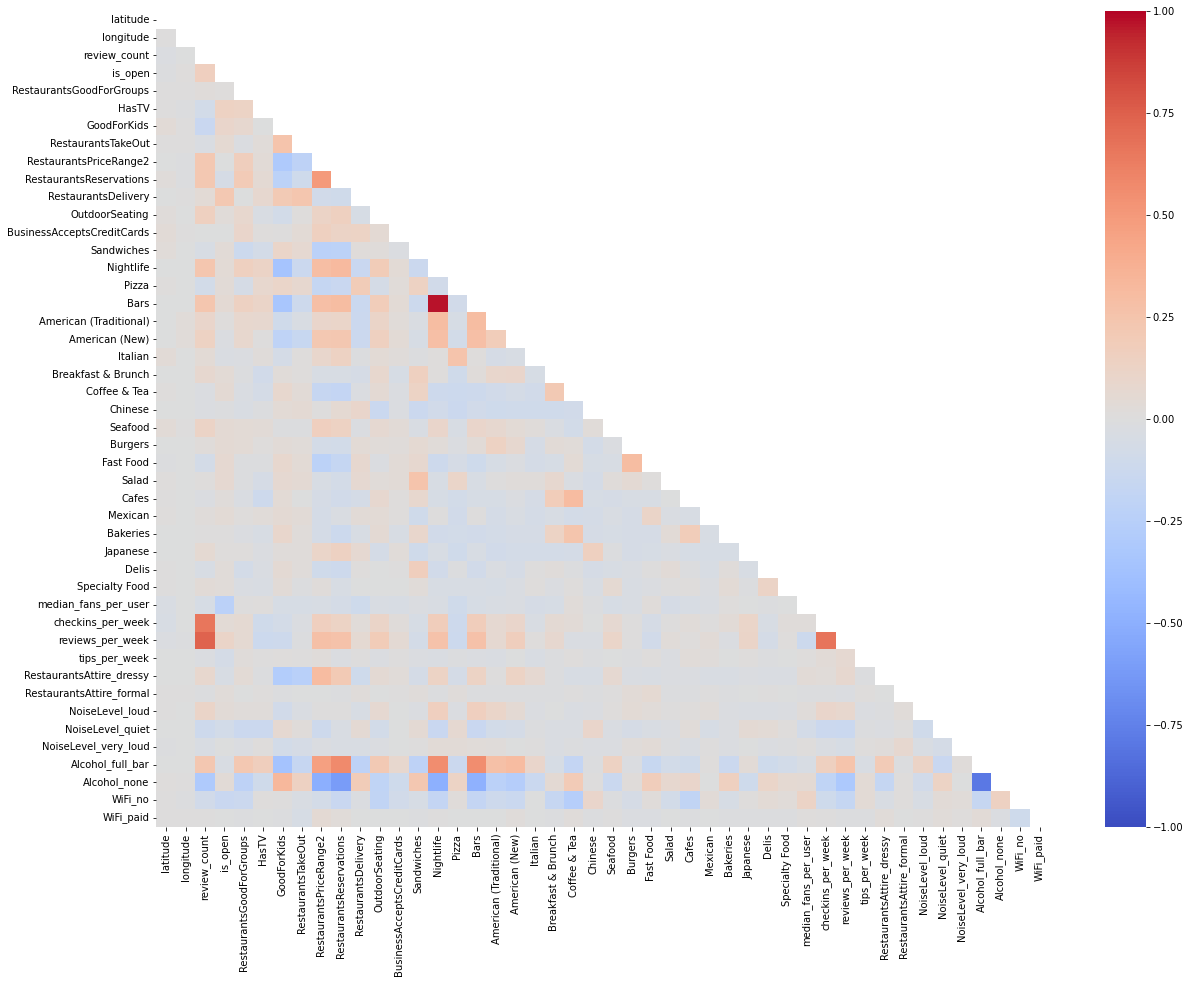

In [13]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(X.corr()))

sns.heatmap(X.corr(), cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.show()

In [14]:
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
          index=X.columns).sort_values(ascending=False)

latitude                      2662.891382
longitude                     2579.878413
RestaurantsTakeOut              27.102772
BusinessAcceptsCreditCards      23.733612
Nightlife                       21.603272
Bars                            21.067431
RestaurantsPriceRange2          15.565550
GoodForKids                      8.488755
Alcohol_none                     8.487701
RestaurantsGoodForGroups         6.107453
HasTV                            5.302901
Alcohol_full_bar                 4.766348
reviews_per_week                 4.315075
RestaurantsDelivery              3.916329
review_count                     3.612782
WiFi_no                          3.498756
is_open                          3.168697
RestaurantsReservations          2.860221
checkins_per_week                2.791397
Pizza                            1.619444
OutdoorSeating                   1.559482
Coffee & Tea                     1.529836
Sandwiches                       1.526075
American (Traditional)           1

In [15]:
X_reduced = X.drop('RestaurantsTakeOut', axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

latitude                      2640.242576
longitude                     2579.878111
BusinessAcceptsCreditCards      23.688537
Nightlife                       21.568119
Bars                            21.034121
RestaurantsPriceRange2          15.379217
Alcohol_none                     8.487641
GoodForKids                      8.368695
RestaurantsGoodForGroups         6.105476
HasTV                            5.297395
Alcohol_full_bar                 4.765257
reviews_per_week                 4.311480
RestaurantsDelivery              3.822743
review_count                     3.612677
WiFi_no                          3.491374
is_open                          3.166996
RestaurantsReservations          2.858995
checkins_per_week                2.790224
Pizza                            1.619415
OutdoorSeating                   1.555707
Coffee & Tea                     1.529736
Sandwiches                       1.525699
American (Traditional)           1.427673
American (New)                   1

In [16]:
X_reduced = X_reduced.drop('BusinessAcceptsCreditCards', axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

latitude                    2621.360237
longitude                   2579.820028
Nightlife                     21.565811
Bars                          21.030987
RestaurantsPriceRange2        15.186198
Alcohol_none                   8.478144
GoodForKids                    8.366073
RestaurantsGoodForGroups       6.093113
HasTV                          5.296924
Alcohol_full_bar               4.765059
reviews_per_week               4.308885
RestaurantsDelivery            3.746709
review_count                   3.601347
WiFi_no                        3.483581
is_open                        3.160765
RestaurantsReservations        2.854797
checkins_per_week              2.790133
Pizza                          1.616959
OutdoorSeating                 1.555523
Coffee & Tea                   1.529321
Sandwiches                     1.525550
American (Traditional)         1.426674
American (New)                 1.390747
median_fans_per_user           1.347321
Italian                        1.329528


In [17]:
X_reduced = X_reduced.drop('Nightlife', axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

latitude                    2621.223417
longitude                   2579.819296
RestaurantsPriceRange2        15.186178
Alcohol_none                   8.470178
GoodForKids                    8.317804
RestaurantsGoodForGroups       6.088778
HasTV                          5.296625
Alcohol_full_bar               4.763175
reviews_per_week               4.308580
RestaurantsDelivery            3.745710
review_count                   3.601153
WiFi_no                        3.483513
is_open                        3.160695
RestaurantsReservations        2.853192
checkins_per_week              2.790105
Bars                           2.015495
Pizza                          1.616695
OutdoorSeating                 1.554847
Coffee & Tea                   1.529216
Sandwiches                     1.525329
American (Traditional)         1.425761
American (New)                 1.390742
median_fans_per_user           1.345304
Italian                        1.328238
NoiseLevel_quiet               1.326637


In [18]:
X_reduced = X_reduced.drop(['Alcohol_full_bar', 'Alcohol_none'], axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

latitude                    2606.256305
longitude                   2579.646606
RestaurantsPriceRange2        14.636160
GoodForKids                    8.154767
RestaurantsGoodForGroups       6.023128
HasTV                          5.185277
reviews_per_week               4.307428
RestaurantsDelivery            3.657407
review_count                   3.557943
WiFi_no                        3.469831
is_open                        3.155005
checkins_per_week              2.789311
RestaurantsReservations        2.392321
Bars                           1.802051
Pizza                          1.616601
OutdoorSeating                 1.542683
Coffee & Tea                   1.524478
Sandwiches                     1.521778
American (Traditional)         1.406434
American (New)                 1.381910
median_fans_per_user           1.344284
NoiseLevel_quiet               1.324283
Italian                        1.317068
Fast Food                      1.316859
Breakfast & Brunch             1.300245


In [19]:
#X_reduced = X_reduced.drop('RestaurantsPriceRange2', axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

latitude                    2606.256305
longitude                   2579.646606
RestaurantsPriceRange2        14.636160
GoodForKids                    8.154767
RestaurantsGoodForGroups       6.023128
HasTV                          5.185277
reviews_per_week               4.307428
RestaurantsDelivery            3.657407
review_count                   3.557943
WiFi_no                        3.469831
is_open                        3.155005
checkins_per_week              2.789311
RestaurantsReservations        2.392321
Bars                           1.802051
Pizza                          1.616601
OutdoorSeating                 1.542683
Coffee & Tea                   1.524478
Sandwiches                     1.521778
American (Traditional)         1.406434
American (New)                 1.381910
median_fans_per_user           1.344284
NoiseLevel_quiet               1.324283
Italian                        1.317068
Fast Food                      1.316859
Breakfast & Brunch             1.300245


In [20]:
X_reduced = X_reduced.drop(['review_count', 'checkins_per_week'], axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

latitude                    2606.238633
longitude                   2579.610244
RestaurantsPriceRange2        14.629304
GoodForKids                    8.119509
RestaurantsGoodForGroups       6.000026
HasTV                          5.182114
RestaurantsDelivery            3.655450
WiFi_no                        3.442164
is_open                        3.076047
RestaurantsReservations        2.373875
reviews_per_week               1.986024
Bars                           1.801655
Pizza                          1.615169
OutdoorSeating                 1.541769
Sandwiches                     1.521247
Coffee & Tea                   1.519976
American (Traditional)         1.398634
American (New)                 1.381809
median_fans_per_user           1.324105
NoiseLevel_quiet               1.321718
Fast Food                      1.316781
Italian                        1.311561
Breakfast & Brunch             1.298274
Chinese                        1.272209
Cafes                          1.267198


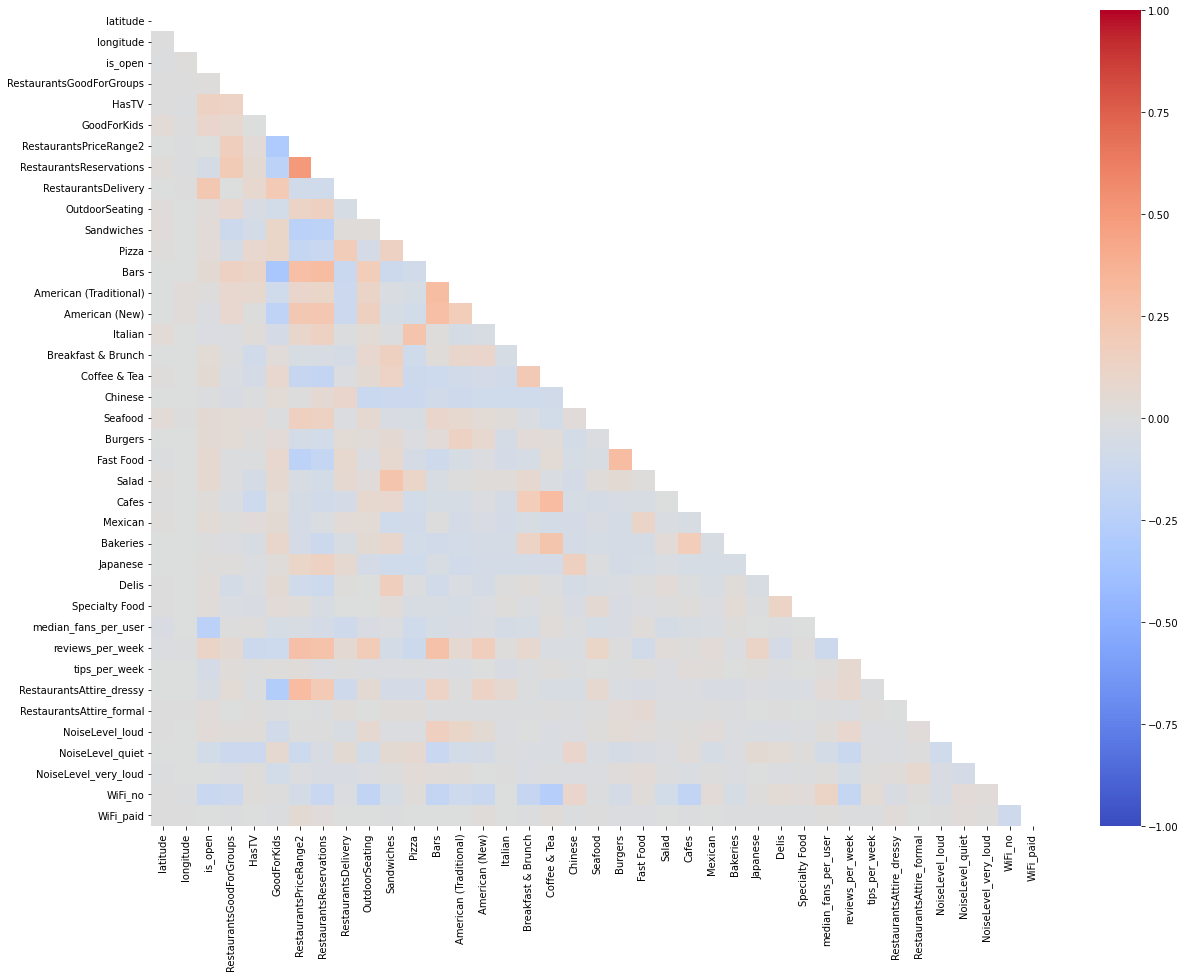

In [21]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(X_reduced.corr()))

sns.heatmap(X_reduced.corr(), cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.show()

In [22]:
X = X_reduced
del X_reduced

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10481 entries, 0 to 10480
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitude                  10481 non-null  float64
 1   longitude                 10481 non-null  float64
 2   is_open                   10481 non-null  int64  
 3   RestaurantsGoodForGroups  10481 non-null  int64  
 4   HasTV                     10481 non-null  int64  
 5   GoodForKids               10481 non-null  int64  
 6   RestaurantsPriceRange2    10481 non-null  int64  
 7   RestaurantsReservations   10481 non-null  int64  
 8   RestaurantsDelivery       10481 non-null  int64  
 9   OutdoorSeating            10481 non-null  int64  
 10  Sandwiches                10481 non-null  int64  
 11  Pizza                     10481 non-null  int64  
 12  Bars                      10481 non-null  int64  
 13  American (Traditional)    10481 non-null  int64  
 14  Americ

In [23]:
df.corr()['stars'].sort_values(ascending=False)

stars                         1.000000
reviews_per_week              0.229150
review_count                  0.146092
checkins_per_week             0.139551
is_open                       0.128617
Cafes                         0.122782
Specialty Food                0.120997
RestaurantsPriceRange2        0.103453
Bakeries                      0.090964
Breakfast & Brunch            0.088539
OutdoorSeating                0.073760
Delis                         0.067590
GoodForKids                   0.058860
Italian                       0.044045
RestaurantsReservations       0.040099
Japanese                      0.036442
Salad                         0.034052
Seafood                       0.032400
Bars                          0.030362
American (New)                0.026829
Nightlife                     0.024161
latitude                      0.023665
Sandwiches                    0.022748
Coffee & Tea                  0.021090
NoiseLevel_quiet              0.008212
longitude                

In [24]:
# Splitting out 20% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=1)

print(f'Shape of X_train: {X_train.shape}. Shaper of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}. Shaper of y_test: {y_test.shape}')

Shape of X_train: (8384, 39). Shaper of y_train: (8384,)
Shape of X_test: (2097, 39). Shaper of y_test: (2097,)


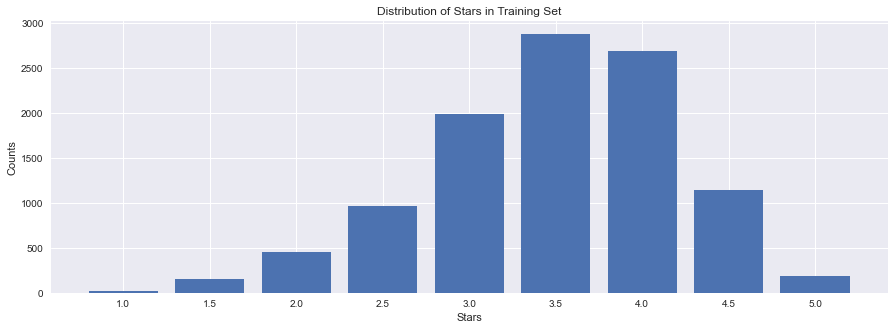

In [49]:
plt.figure(figsize=(15,5))
plt.bar(y.value_counts().sort_index().index.astype('str'),
        y.value_counts().sort_index())
plt.title('Distribution of Stars in Training Set')
plt.xlabel('Stars')
plt.ylabel('Counts')
plt.show()

In [25]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [26]:
X_train_scaled.head()

,latitude,longitude,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsDelivery,OutdoorSeating,...,median_fans_per_user,reviews_per_week,tips_per_week,RestaurantsAttire_dressy,RestaurantsAttire_formal,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,WiFi_no,WiFi_paid
0,0.254724,0.002703,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,...,0.021277,0.005745,0.000824,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.754523,0.003503,1.0,1.0,1.0,1.0,0.333333,1.0,1.0,0.0,...,0.000000,0.020894,0.000758,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.191141,0.002766,1.0,1.0,1.0,1.0,0.333333,0.0,0.0,1.0,...,0.000000,0.047119,0.004285,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.491518,0.002418,1.0,0.0,1.0,0.0,0.333333,0.0,0.0,0.0,...,0.000000,0.054754,0.001983,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.464406,0.002234,1.0,1.0,1.0,1.0,1.000000,1.0,0.0,0.0,...,0.021277,0.018207,0.005019,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
X_test_scaled.head()

,latitude,longitude,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsDelivery,OutdoorSeating,...,median_fans_per_user,reviews_per_week,tips_per_week,RestaurantsAttire_dressy,RestaurantsAttire_formal,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,WiFi_no,WiFi_paid
0,0.469234,0.002342,0.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.0,...,0.063830,0.006323,0.001457,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.422707,0.001184,1.0,1.0,1.0,1.0,0.333333,0.0,1.0,1.0,...,0.000000,0.039157,0.001967,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.465875,0.001352,0.0,1.0,1.0,1.0,0.333333,0.0,1.0,0.0,...,0.021277,0.080796,0.006143,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.494877,0.002663,0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,...,0.989362,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.468201,0.002344,1.0,1.0,1.0,0.0,0.666667,1.0,0.0,0.0,...,0.000000,0.008244,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Linear Regression

In [28]:
# Define the model
lin_reg = LinearRegression()

# Cross validation score on MAE
scores = cross_val_score(lin_reg, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=5)
print(-scores)
print(np.mean(-scores))

[0.51776418 0.49697378 0.51560113 0.51773269 0.49095901]
0.507806155309309


In [29]:
# Cross validation score on R^2
scores = cross_val_score(lin_reg, X_train_scaled, y_train, scoring='r2', cv=5)
print(scores)
print(np.mean(scores))

[ 0.20971538  0.2208863  -0.32927924  0.19747639  0.19766677]
0.09929312135364439


In [30]:
# Cross validation score on root mean squared error
scores = cross_val_score(lin_reg, X_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(-scores)
print(np.mean(-scores))

[0.65600102 0.62813303 0.83651264 0.65252662 0.62669847]
0.679974353219298


In [35]:
# Evaluate the model
lin_reg.fit(X_train, y_train)

prediction = lin_reg.predict(X_test)

print(f'The R^2 score is: {r2_score(y_test, prediction)}')
print(f'The MAE is: {mean_absolute_error(y_test, prediction)}')
print(f'The RSME is: {np.sqrt(mean_squared_error(y_test, prediction))}')

The R^2 score is: 0.19266045121533526
The MAE is: 0.5102810957770557
The RSME is: 0.6488383227895629


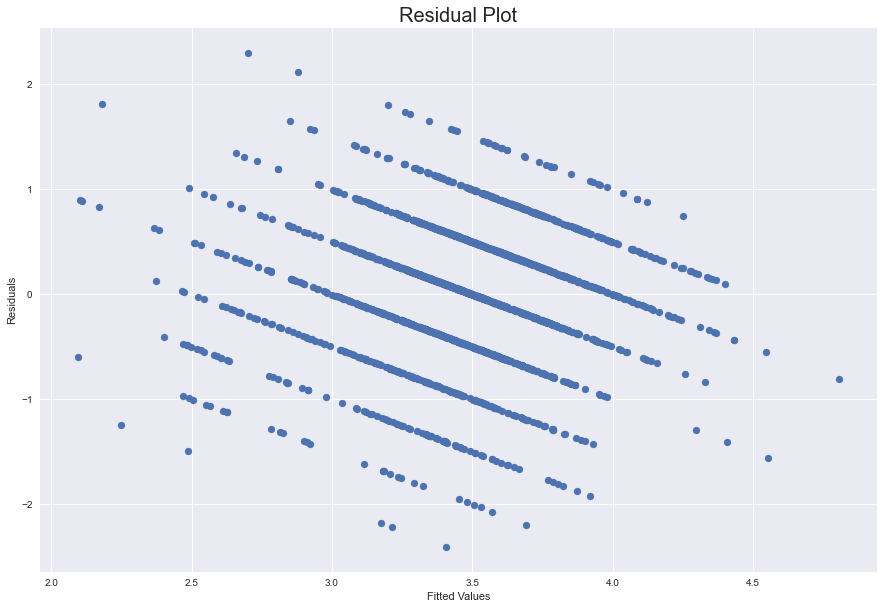

In [50]:
residuals = (y_test - prediction)

plt.figure(figsize=(15,10))
plt.scatter(prediction, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot', fontsize=20)
plt.show()

## Ridge Regression

In [71]:
# Define the model
ridge_reg = Ridge(alpha=1.0)

# Cross validation score on MAE
scores = cross_val_score(ridge_reg, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=5)
print(-scores)
print(np.mean(-scores))

[0.51791503 0.49695922 0.50300671 0.51788777 0.49089874]
0.5053334964220006


In [72]:
# Cross validation score on R^2
scores = cross_val_score(ridge_reg, X_train_scaled, y_train, scoring='r2', cv=5)
print(scores)
print(np.mean(scores))

[0.20940763 0.2205295  0.22067327 0.19783588 0.1980809 ]
0.2093054362319529


In [73]:
# Cross validation score on root mean squared error
scores = cross_val_score(ridge_reg, X_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(-scores)
print(np.mean(-scores))

[0.65612873 0.62827684 0.64050745 0.65238045 0.62653671]
0.6407660357244462


## Lasso Regression

## Decision Tree

## Random Forest